In [1]:
import fastparquet
import numpy as np
import pandas as pd
import seaborn as sns
sns.set()
# import matplotlib.pylab as plt


In [2]:
df = pd.read_parquet('dataset/2022_place_deephaven.parquet', engine='fastparquet')
df['timestamp'] = pd.to_datetime(df['timestamp'],unit='ns')

In [46]:
# group by hour pr day and count the number of observations in each hour
df_hour = df.groupby([df['timestamp'].dt.date, df['timestamp'].dt.hour]).count()

In [39]:
# concat the two indexes to a timestamp 
df_hour['timestamp'] = df_hour.index.map(lambda x: pd.Timestamp(x[0].strftime('%Y-%m-%d') + ' ' + str(x[1]) + ':00:00'))

<AxesSubplot:title={'center':'Number of actions per hour'}, xlabel='timestamp'>

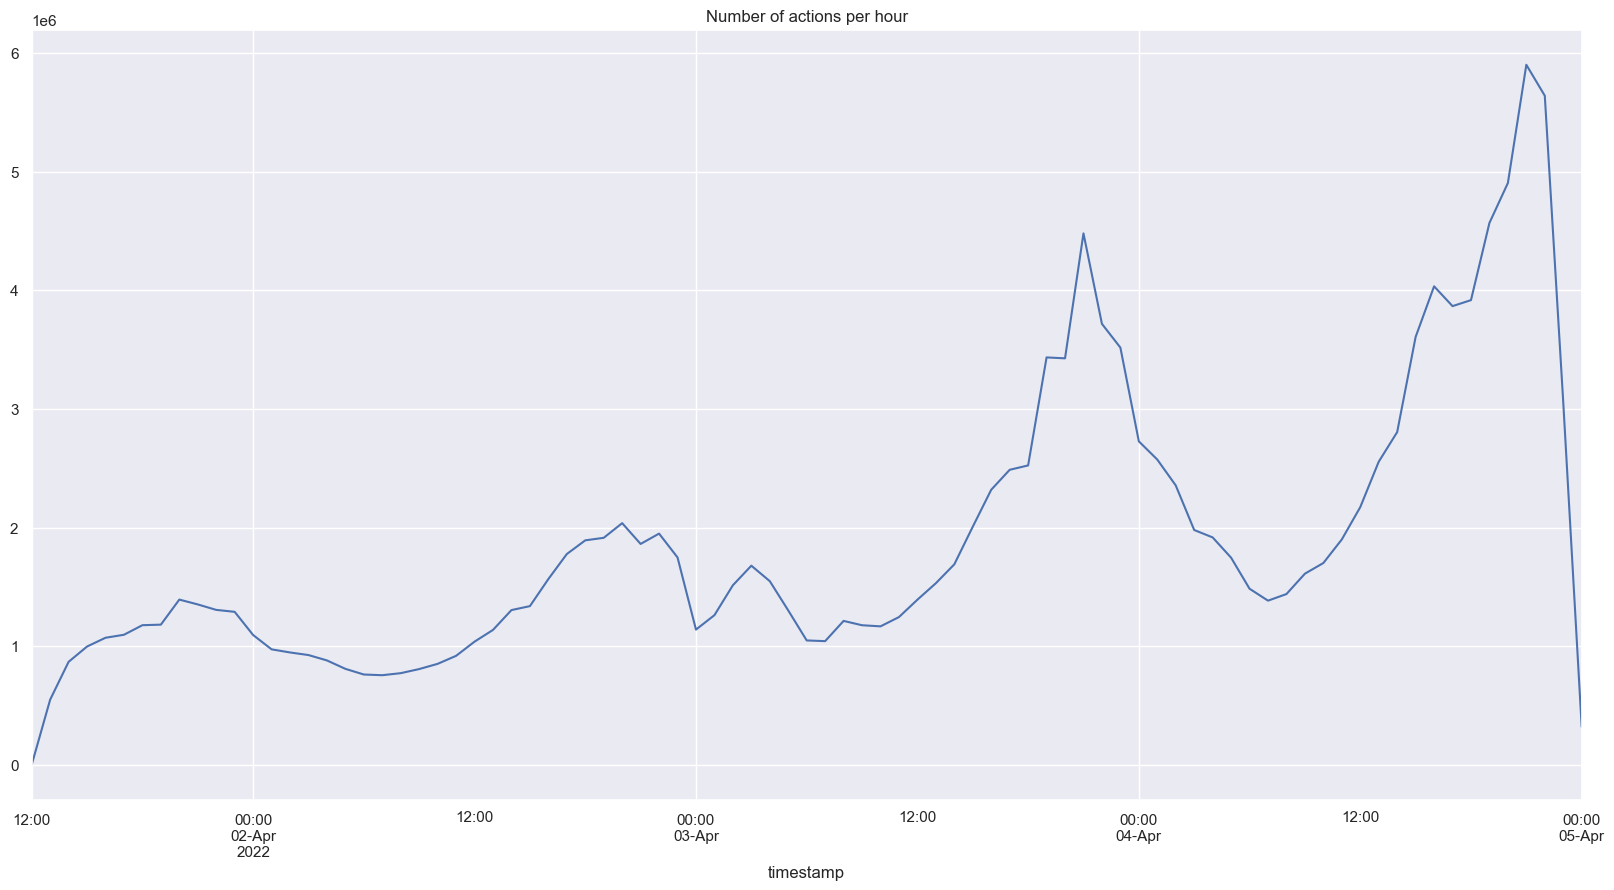

In [45]:
# plot the number of observations per hour
df_hour.plot(x='timestamp', y='user_id', figsize=(20,10), title='Number of actions per hour', legend=False)

In [4]:
from PIL import Image
import os
class PlaceCanvas:
    def __init__(self, width, height):
        self.canvas = Image.new('RGB', (width, height), color = 'white')


    def update_pixel_hex(self, x,y,color):
        """
        Sets the specific x,y coordinate in the canvas to the given hex color.

        example:
        update_pixel(10,10,"#B4FBB8")
        """
        h = color.lstrip('#')
        rgb_value = tuple(int(h[i:i+2], 16) for i in (0, 2, 4))
        self.canvas.putpixel((x,y), rgb_value)

    def update_pixel_int(self, x,y,color):
        """
        Sets the specific x,y coordinate in the canvas to the given hex color.

        example:
        update_pixel(10,10, 8318294)
        """
        self.canvas.putpixel((x,y), self.getRGBfromI(color))

    def save_canvas(self, path = "images/"):
        name = ''
        if(os.path.exists(f'{path}images.png')):
            i = 0 
            while(os.path.exists(f'{path}images {i}.png')):
                i += 1
            self.canvas.save(f'{path}images {i}.png')
            return f'images {i}.png'
        else:
            self.canvas.save(f'{path}images.png')
            return 'images.png'

    def get_image(self):
        return self.canvas

    def getRGBfromI(self, RGBint):
        blue =  RGBint & 255
        green = (RGBint >> 8) & 255
        red =   (RGBint >> 16) & 255
        return red, green, blue

In [13]:
canvas = PlaceCanvas(1000,1000)
lastsave = df.iloc[0]['timestamp']
df_images = pd.DataFrame(columns=['timestamp','image'])
# Batch the df in million chunks
for i in range(0, len(df), 1000000):
    print(f'Processing {i} to {i+1000000}')
    # check to see if out of bounds
    if(i+1000000 > len(df)):
        df_chunk = df.iloc[i:]
    else:
        df_chunk = df.iloc[i:i+1000000]
    # iterate through the chunk
    for index, row in df_chunk.iterrows():
        if row['x1'] < 1000 and row['y1'] < 1000:
            canvas.update_pixel_int(row['x1'],row['y1'],row['rgb'])
        if row['timestamp'] - lastsave > pd.Timedelta('30m'):
            lastsave = row['timestamp']
            df_images = df_images.append({'timestamp': row['timestamp'], 'image': canvas.save_canvas()}, ignore_index=True)
        


Processing 0 to 1000000
Processing 1000000 to 2000000
Processing 2000000 to 3000000
Processing 3000000 to 4000000
Processing 4000000 to 5000000
Processing 5000000 to 6000000
Processing 6000000 to 7000000
Processing 7000000 to 8000000
Processing 8000000 to 9000000
Processing 9000000 to 10000000
Processing 10000000 to 11000000
Processing 11000000 to 12000000
Processing 12000000 to 13000000
Processing 13000000 to 14000000
Processing 14000000 to 15000000
Processing 15000000 to 16000000
Processing 16000000 to 17000000
Processing 17000000 to 18000000
Processing 18000000 to 19000000
Processing 19000000 to 20000000
Processing 20000000 to 21000000
Processing 21000000 to 22000000
Processing 22000000 to 23000000
Processing 23000000 to 24000000
Processing 24000000 to 25000000
Processing 25000000 to 26000000
Processing 26000000 to 27000000
Processing 27000000 to 28000000
Processing 28000000 to 29000000
Processing 29000000 to 30000000
Processing 30000000 to 31000000
Processing 31000000 to 32000000
P

KeyboardInterrupt: 

In [14]:
df_images.to_csv('timestamp_images.csv', index=False)

: 

In [3]:
df.head()

,timestamp,user_id,pixel_color,coordinate
0,2022-04-04 00:53:51.577 UTC,ovTZk4GyTS1mDQnTbV+vDOCu1f+u6w+CkIZ6445vD4XN8a...,#00CCC0,"826,1048"
1,2022-04-04 00:53:53.758 UTC,6NSgFa1CvIPly1VniNhlbrmoN3vgDFbMSKqh+c4TTfrr3d...,#94B3FF,"583,1031"
2,2022-04-04 00:53:54.685 UTC,O5Oityp3Z3owzTuwM9XnMggpLcqKEumsOMKGhRiDTTImWb...,#6A5CFF,"1873,558"
3,2022-04-04 00:54:57.541 UTC,tc273UiqS0wKa6VwiOs/iz/t4LyPYrhL2Q347awn11IQQE...,#009EAA,"1627,255"
4,2022-04-04 00:55:16.307 UTC,OOWsU/HLb4UUkQwclDeXFtsJTOXMlAdNHiRpFA1Qk+SxUr...,#94B3FF,"49,1478"


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1175317 entries, 0 to 1175316
Data columns (total 4 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   timestamp    1175317 non-null  object
 1   user_id      1175317 non-null  object
 2   pixel_color  1175317 non-null  object
 3   coordinate   1175317 non-null  object
dtypes: object(4)
memory usage: 35.9+ MB


In [5]:
df[['x', 'y']] = df.coordinate.str.split(",",1, expand=True)
df['x'] = df['x'].astype(int)
df['y'] = df['y'].astype(int)

In [6]:
df.head()

,timestamp,user_id,pixel_color,coordinate,x,y
0,2022-04-04 00:53:51.577 UTC,ovTZk4GyTS1mDQnTbV+vDOCu1f+u6w+CkIZ6445vD4XN8a...,#00CCC0,"826,1048",826,1048
1,2022-04-04 00:53:53.758 UTC,6NSgFa1CvIPly1VniNhlbrmoN3vgDFbMSKqh+c4TTfrr3d...,#94B3FF,"583,1031",583,1031
2,2022-04-04 00:53:54.685 UTC,O5Oityp3Z3owzTuwM9XnMggpLcqKEumsOMKGhRiDTTImWb...,#6A5CFF,"1873,558",1873,558
3,2022-04-04 00:54:57.541 UTC,tc273UiqS0wKa6VwiOs/iz/t4LyPYrhL2Q347awn11IQQE...,#009EAA,"1627,255",1627,255
4,2022-04-04 00:55:16.307 UTC,OOWsU/HLb4UUkQwclDeXFtsJTOXMlAdNHiRpFA1Qk+SxUr...,#94B3FF,"49,1478",49,1478


In [7]:
canvas = PlaceCanvas(2000,2000)

In [8]:
video_name = 'video.avi'
video = cv2.VideoWriter(video_name, 0, 1, (2000,2000))

In [9]:
for index, row in df.iterrows():
    canvas.update_pixel(row.x, row.y, row.pixel_color)
canvas.save_canvas()

TypeError: Expected cv::UMat for argument 'image'